# Taxi Orders Prediction

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

**Executive Summary**

Goal achieved, the chosen model's RMSE metric on the test set is 34.83  


## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from IPython.display import display

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the data into a df
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Looking at the beginning and end of the data
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
# Lookig at the general info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Reload the data into a df, now turning the datetime into the index and into Datetime data type
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
# Check it is sorted:
df.index.is_monotonic

True

In [7]:
# Resample by one hour
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


We have now the data per hour, with the datetime as index, with full sorted data from the begining of March 2018 untill the end of August.

## Analysis

In [8]:
# General statistics of the num_orders
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


No negative values, no impossible values (462 looks very high, but not impossible). 

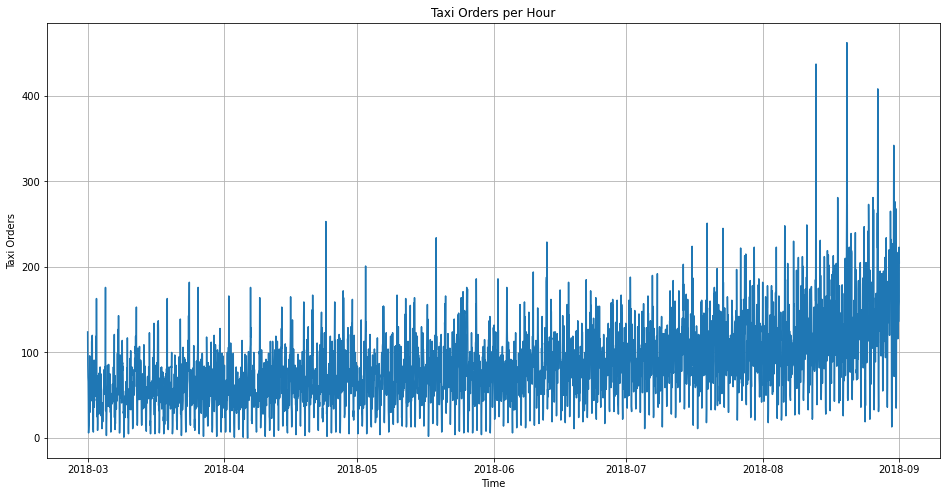

In [10]:
# Plotting the orders-per-hour along the time
plt.figure(figsize=(16,8))
plt.title('Taxi Orders per Hour')
plt.xlabel('Time')
plt.ylabel('Taxi Orders')
plt.grid(True)
plt.plot(df);

We can see a general mild positive trend, especially in the second half of the time-span. Along the whole period we can see fluctuation that increase with time. Extreme peaks (above 200 untill July or above 300 in August) are rare. 

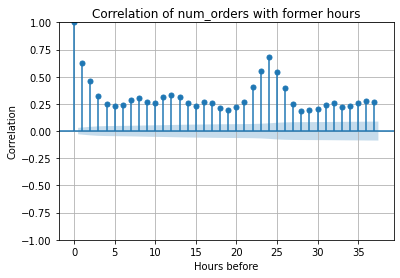

In [12]:
# Plotting Autocorelation 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.values)
plt.title('Correlation of num_orders with former hours')
plt.xlabel('Hours before')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

We can clearly see that the 2 highest correlated values come form 1 hour earlier and especially from 24 hours (full day) earlier (almost o.75 correlation), and lower for 23 and 25 hours earlier. All the rest show correlation under 0.5. 

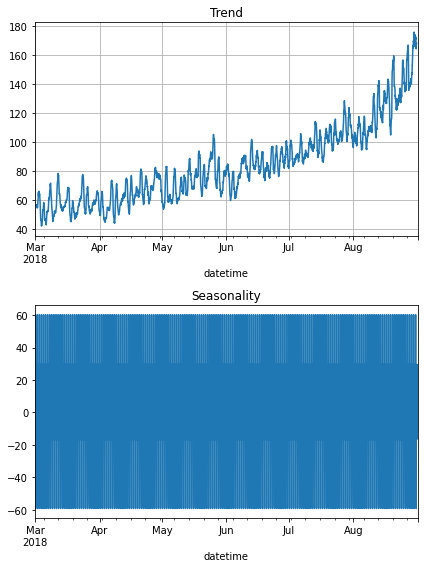

In [13]:
# Plotting trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df) 

plt.figure(figsize=(6, 8))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.grid(True)
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

The positive **trend** is very clear - and following it we will focus for prediction on data relatively close to the predicted hour. The **seasonality** is much too dense when looking at the whole 6 months, so we will try to see it on 1 month. We will choose the last month.   

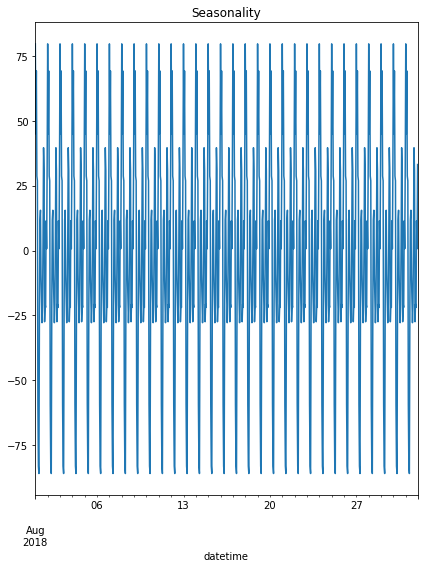

In [14]:
# Plotting seasonality of the last month
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31']) 

plt.figure(figsize=(6, 8))
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

The seasonality clearly supports our earlier correlation conclusion about 1 Day seasonality. This will influence our model bulding. 

## Training

### Preparing for training

Following the above analysis and other considerations, we will add to our data the following features:

1. Month (because of the general positive trend)
2. Day of week (because it might influence peaks, for example weekends)
3. Hour (following the correlation and seasonality analysis)
4. Number of orders 1 hour earlier (following the correlation analysis)
5. Number of orders 24 hours earlier - for the whole earlier week (to catch optional weekly correlations)

We will not use rolling mean, since both the positive trend and the 24H seasonality seem to make such a mean less predictive.

In [15]:
# Features creation
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

df['1_hour_earlier'] = df['num_orders'].shift(1)
for lag in range(1, 8):
    df['{}_days_earlier'.format(lag)] = df['num_orders'].shift(lag*24)

In [16]:
# Dropping the entries with missing values  
df.dropna(inplace=True)
df

,num_orders,month,dayofweek,hour,1_hour_earlier,1_days_earlier,2_days_earlier,3_days_earlier,4_days_earlier,5_days_earlier,6_days_earlier,7_days_earlier
datetime,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,3,0,94.0,100.0,42.0,86.0,75.0,163.0,90.0,124.0
2018-03-08 01:00:00,78,3,3,1,143.0,121.0,75.0,176.0,60.0,108.0,120.0,85.0
2018-03-08 02:00:00,65,3,3,2,78.0,24.0,36.0,32.0,26.0,25.0,75.0,71.0
2018-03-08 03:00:00,68,3,3,3,65.0,66.0,49.0,51.0,42.0,64.0,64.0,66.0
2018-03-08 04:00:00,60,3,3,4,68.0,73.0,30.0,34.0,27.0,44.0,20.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,4,19,207.0,72.0,169.0,111.0,152.0,126.0,123.0,113.0
2018-08-31 20:00:00,154,8,4,20,136.0,142.0,191.0,94.0,96.0,122.0,105.0,179.0
2018-08-31 21:00:00,159,8,4,21,154.0,198.0,170.0,189.0,152.0,107.0,162.0,166.0


All seem ok for now. We will move to splitting our data into train, validation and test sets.

In [17]:
# Split the data into 3 sets, according to the chronological order
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

Now we will - only on our train set - check to what extent our features have correlation with the number of orders (our target). 

In [18]:
# Checking correlation in the train set
train.corr()

,num_orders,month,dayofweek,hour,1_hour_earlier,1_days_earlier,2_days_earlier,3_days_earlier,4_days_earlier,5_days_earlier,6_days_earlier,7_days_earlier
num_orders,1.000000,0.383553,0.005852,0.032304,0.533101,0.638808,0.679300,0.654643,0.653825,0.673014,0.608814,0.763716
month,0.383553,1.000000,-0.003178,-0.003805,0.384608,0.381263,0.379685,0.377450,0.380473,0.375583,0.371806,0.371558
dayofweek,0.005852,-0.003178,1.000000,-0.004011,-0.001012,0.055933,0.036006,-0.040053,-0.059153,-0.044067,0.061103,0.007155
hour,0.032304,-0.003805,-0.004011,1.000000,-0.064477,0.034459,0.037178,0.039049,0.041654,0.041407,0.044786,0.047410
1_hour_earlier,0.533101,0.384608,-0.001012,-0.064477,1.000000,0.444613,0.478075,0.454418,0.452795,0.469273,0.426815,0.506199
1_days_earlier,0.638808,0.381263,0.055933,0.034459,0.444613,1.000000,0.637060,0.678410,0.653279,0.652591,0.673309,0.607728
2_days_earlier,0.679300,0.379685,0.036006,0.037178,0.478075,0.637060,1.000000,0.635862,0.679992,0.654973,0.651166,0.672461
3_days_earlier,0.654643,0.377450,-0.040053,0.039049,0.454418,0.678410,0.635862,1.000000,0.634504,0.679240,0.654016,0.649253
4_days_earlier,0.653825,0.380473,-0.059153,0.041654,0.452795,0.653279,0.679992,0.634504,1.000000,0.633223,0.679280,0.652859
5_days_earlier,0.673014,0.375583,-0.044067,0.041407,0.469273,0.652591,0.654973,0.679240,0.633223,1.000000,0.632499,0.679707


Since it is reasonable that forecasting of orders based on past data doesn't necessarily involve non-linear relations - we will use the correlation results from above to improve our features selection and impprovement: we will drop the features that yield correlation lower than 0.5, and duplicate a few times the 1 column that yield the highest correlation (much higher than all the rest) - as could have been expected, the exact same hour of the day, 7 days (a full week) before the current day.   

In [19]:
# Features selection and duplication
def features_improvement(data):
    data = data.drop(['month', 'dayofweek', 'hour'], axis=1)
    data['7_days_earlier*'] = data['7_days_earlier']
    data['7_days_earlier**'] = data['7_days_earlier']
    data['7_days_earlier***'] = data['7_days_earlier']
    return data 

train = features_improvement(train) 
train.corr()

,num_orders,1_hour_earlier,1_days_earlier,2_days_earlier,3_days_earlier,4_days_earlier,5_days_earlier,6_days_earlier,7_days_earlier,7_days_earlier*,7_days_earlier**,7_days_earlier***
num_orders,1.000000,0.533101,0.638808,0.679300,0.654643,0.653825,0.673014,0.608814,0.763716,0.763716,0.763716,0.763716
1_hour_earlier,0.533101,1.000000,0.444613,0.478075,0.454418,0.452795,0.469273,0.426815,0.506199,0.506199,0.506199,0.506199
1_days_earlier,0.638808,0.444613,1.000000,0.637060,0.678410,0.653279,0.652591,0.673309,0.607728,0.607728,0.607728,0.607728
2_days_earlier,0.679300,0.478075,0.637060,1.000000,0.635862,0.679992,0.654973,0.651166,0.672461,0.672461,0.672461,0.672461
3_days_earlier,0.654643,0.454418,0.678410,0.635862,1.000000,0.634504,0.679240,0.654016,0.649253,0.649253,0.649253,0.649253
4_days_earlier,0.653825,0.452795,0.653279,0.679992,0.634504,1.000000,0.633223,0.679280,0.652859,0.652859,0.652859,0.652859
5_days_earlier,0.673014,0.469273,0.652591,0.654973,0.679240,0.633223,1.000000,0.632499,0.679707,0.679707,0.679707,0.679707
6_days_earlier,0.608814,0.426815,0.673309,0.651166,0.654016,0.679280,0.632499,1.000000,0.633158,0.633158,0.633158,0.633158
7_days_earlier,0.763716,0.506199,0.607728,0.672461,0.649253,0.652859,0.679707,0.633158,1.000000,1.000000,1.000000,1.000000
7_days_earlier*,0.763716,0.506199,0.607728,0.672461,0.649253,0.652859,0.679707,0.633158,1.000000,1.000000,1.000000,1.000000


As we can see now in the first column, we have now only features with significant (>0.5) correlation with our target, and with the highest correlated features duplicated a few times. We will see below if this will enable us to recieve RMSE lower than the needed threshold. 

Now we will define features and target for each dataset, create a function for calculating RMSE, improve the features of the validation set (just like we did for the train set), and define our function for training and evaluating (on the validation set) each model.

In [20]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_valid = valid.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [21]:
# Function to calculate RMSE
def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

In [22]:
# Feature selection and duplication for the validation set
X_valid = features_improvement(X_valid) 

In [23]:
# Function for training, predicting and evaluating each model on the (train and) validation set
def train_model(model):
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)

    print(model)
    print("RMSE train:", rmse(y_train, pred_train))
    print("RMSE valid:", rmse(y_valid, pred_valid))

### Linear regression

Since linear regression is not very good for hyperparameter tuning, we will use it in it's default form. For the next models we will tune hyperparameters. 

In [24]:
model = LinearRegression()
train_model(model)

LinearRegression()
RMSE train: 20.506365237819214
RMSE valid: 29.591375221064983


It is only on the validation set for now - but the RMSE is promissing relative to the threshold. 

### Random forest regressor 

In [25]:
n_estimators_list = [10, 40, 70, 100, 150]
for n in n_estimators_list:
    model = RandomForestRegressor(n_estimators=n)
    train_model(model)
    print()

RandomForestRegressor(n_estimators=10)
RMSE train: 9.187899809367575
RMSE valid: 31.293822328486705

RandomForestRegressor(n_estimators=40)
RMSE train: 8.099904647909911
RMSE valid: 30.737075230634446

RandomForestRegressor(n_estimators=70)
RMSE train: 7.948171883132363
RMSE valid: 30.93500821574914

RandomForestRegressor()
RMSE train: 7.864651696555896
RMSE valid: 30.554926726446027

RandomForestRegressor(n_estimators=150)
RMSE train: 7.813484081277193
RMSE valid: 30.642268710683663



The default value of 100 estimators yielded the best RMSE on the validation set (although with very small differences from other values). It is close (and a little higher) than the one we got with LR. 

### LightGBM regressor

In [26]:
import lightgbm as lgbm
# print('On validation set:')
num_leaves_list = [30, 50, 100]
max_depth_list = [0, 5, 8]
n_estimators_list = [10, 50, 80]
for n in num_leaves_list:
    for m in max_depth_list:
        for e in n_estimators_list:
            model = lgbm.LGBMRegressor(num_leaves=n, max_depth=m, n_estimators=e)
            train_model(model)
            print()

LGBMRegressor(max_depth=0, n_estimators=10, num_leaves=30)
RMSE train: 22.11195988097977
RMSE valid: 36.6722687266457

LGBMRegressor(max_depth=0, n_estimators=50, num_leaves=30)
RMSE train: 15.938093036858664
RMSE valid: 30.169386276386312

LGBMRegressor(max_depth=0, n_estimators=80, num_leaves=30)
RMSE train: 14.59005443265779
RMSE valid: 30.179121175155885

LGBMRegressor(max_depth=5, n_estimators=10, num_leaves=30)
RMSE train: 22.29103810101097
RMSE valid: 36.947466215669365

LGBMRegressor(max_depth=5, n_estimators=50, num_leaves=30)
RMSE train: 17.44913638673031
RMSE valid: 30.143767397220913

LGBMRegressor(max_depth=5, n_estimators=80, num_leaves=30)
RMSE train: 16.75920406535887
RMSE valid: 30.057843238312977

LGBMRegressor(max_depth=8, n_estimators=10, num_leaves=30)
RMSE train: 22.113263970928084
RMSE valid: 36.677668409086635

LGBMRegressor(max_depth=8, n_estimators=50, num_leaves=30)
RMSE train: 16.252545032370598
RMSE valid: 30.39422343178216

LGBMRegressor(max_depth=8, n_est

The best RMSE on the validation set here was between the LR and the RFR, and a few hyperparameters combinations were very close in results. We will choose the one that got the lowest RMSE on validation set: LGBMRegressor(max_depth=5, n_estimators=80, num_leaves=30). 

## Testing

Since we have a clear threshold of RMSE (not more than 48) - we don't need a dummy model as a baseline.

Before testing each best (of it's kind, after hyperparameters tuning) model on the test set - we will train each one more time on the whole train+valid sets, so we will first prepare the train_valid set (and also apply the feature selection and duplicaion on the test set).  

In [27]:
# Preparing train_valid set, and feature selection and duplication for it and for the test set
X_train_valid = train_valid.drop(['num_orders'], axis=1)
y_train_valid = train_valid['num_orders']

X_train_valid = features_improvement(X_train_valid)
X_test = features_improvement(X_test) 

In [28]:
# Function for last training (on train+valid) and testing each model on the (train_valid and) test set
def train_test_model(model):
    model.fit(X_train_valid, y_train_valid)

    pred_train_valid = model.predict(X_train_valid)
    pred_test = model.predict(X_test)

    print(model)
    print("RMSE train_valid:", rmse(y_train_valid, pred_train_valid))
    print("RMSE test:", rmse(y_test, pred_test))

### Linear regression

In [29]:
model = LinearRegression()
train_test_model(model)

LinearRegression()
RMSE train_valid: 21.58162382952192
RMSE test: 34.83113499621637


### Random forest regressor

In [30]:
model = RandomForestRegressor()
train_test_model(model)

RandomForestRegressor()
RMSE train_valid: 8.461127005703435
RMSE test: 41.52294506726159


### LightGBM regressor

In [31]:
model = lgbm.LGBMRegressor(max_depth=5, n_estimators=80, num_leaves=30) 
train_test_model(model)

LGBMRegressor(max_depth=5, n_estimators=80, num_leaves=30)
RMSE train_valid: 18.182449979270647
RMSE test: 39.46758845404724


## Conclusion

Our chosen model is the linear regression, that yielded RMSE of 34.83, less than 3/4 of the needed threshold of 48.   